# Stock Market Prediction Model of the Magnificient Seven 

#pip install the dependencies from requirements. May take up to 12 minutes

In [1]:
!python3 -m pip install -r requirements.txt


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


### importing our libraries after pipinstall

In [3]:

#python data manipulation
import pandas as pd
import numpy as np

#data visualizaiton tools, EDA
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

#mysql and Cassandra
from cassandra.cluster import Cluster          

#ARIMA
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

#LSTM Neural network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf

# our finance data
import yfinance as yf



## Extracting the Historical Data.


 ### The historical aspect of the data is starting from January 1st 2020 to yesterday (april 6th), We can adjust this to most recent always. We extracted the 7 companies and start with first 7 features from our project proposal: Date/time, open price, low price, high price, adjusted close price, trading volume

In [172]:
def extract_data(tickers, start_date="2020-01-01", end_date="2025-04-06", interval="1d"):
    # importing the yfinance api data, making sure the autoadjust is off because it overrides the close value if its on
    df = yf.download(tickers, start=start_date, end=end_date, interval=interval, auto_adjust=False)
    # tidying the data to make it better for analysis and transformation later
    df.columns = df.columns.swaplevel(0, 1)
    df = df.sort_index(axis=1, level=0)
    df_flat = df.stack(level=0, future_stack=True).reset_index()  
    df_flat.rename(columns={'level_0': 'Date'}, inplace=True)
    # renaming 'Adj Close' to 'Adj_Close' for consistency
    if 'Adj Close' in df_flat.columns:
        df_flat.rename(columns={'Adj Close': 'Adj_Close'}, inplace=True)
    # adding the previous day's close price per ticker
    df_flat['Previous_Close'] = df_flat.groupby('Ticker')['Close'].shift(1)
    # selecting the columns we expect and need
    expected_cols = ['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Adj_Close', 'Previous_Close', 'Volume']
    existing_cols = [col for col in expected_cols if col in df_flat.columns]
    return df_flat[existing_cols]


In [173]:
#giving yfinance a list of companies to return a list of data of. AND displaying the df
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "META", "NVDA", "TSLA"]
df_raw = extract_data(tickers)
display(df_raw)

[*********************100%***********************]  7 of 7 completed


Price,Date,Ticker,Open,High,Low,Close,Adj_Close,Previous_Close,Volume
0,2020-01-02,AAPL,74.059998,75.150002,73.797501,75.087502,72.716064,NaN,135480400
1,2020-01-02,AMZN,93.750000,94.900497,93.207497,94.900497,94.900497,NaN,80580000
2,2020-01-02,GOOGL,67.420502,68.433998,67.324501,68.433998,68.108368,NaN,27278000
3,2020-01-02,META,206.750000,209.789993,206.270004,209.779999,208.795944,NaN,12077100
4,2020-01-02,MSFT,158.779999,160.729996,158.330002,160.619995,153.323257,NaN,22622100
...,...,...,...,...,...,...,...,...,...
9249,2025-04-04,GOOGL,148.009995,151.070007,145.380005,145.600006,145.600006,150.720001,62138600
9250,2025-04-04,META,506.619995,518.000000,494.200012,504.730011,504.730011,531.619995,38515100
9251,2025-04-04,MSFT,364.130005,374.589996,359.480011,359.839996,359.839996,373.109985,49138700
9252,2025-04-04,NVDA,98.910004,100.129997,92.110001,94.309998,94.309998,101.800003,529707700


## Historical Data: Data Cleaning: 
### We will clean the data by taking care of any null values. We can use back and forward filling if there is a value missing from a float/int value. Otherwise we will drop the value if its in the date or Ticker/ or use the average of the past few days for the column. Additionally if there are are any duplicate records for a company and a speciifc date, one should be kept while rest dropped.

In [174]:
nans = df_raw.isna().sum()
print(nans)
def cleaning(df):
    # Step 1: Drop duplicates (keep the first entry for each Ticker-Date pair)
    df = df.drop_duplicates(subset=['Date', 'Ticker'], keep='first')

    # Step 2: Define numeric columns to clean (excluding 'Date' and 'Ticker')
    numeric_cols = ['Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume', 'Previous_Close']
    
    # Step 3: Fill missing values for numeric columns
    for col in numeric_cols:
        # Forward fill and backward fill first
        df[col] = df.groupby('Ticker')[col].transform(lambda x: x.ffill().bfill())
        
        # Fill remaining NaNs with rolling mean (3-day window)
        df[col] = df.groupby('Ticker')[col].transform(
            lambda x: x.fillna(x.rolling(window=3, min_periods=1).mean())
        )

    # Step 4: Ensure 'Previous_Close' is properly filled (first entry has no previous data)
    df['Previous_Close'] = df.groupby('Ticker')['Previous_Close'].ffill()

    # Step 5: Drop rows with nulls in 'Date' or 'Ticker' (shouldn't exist, but safety check)
    df = df.dropna(subset=['Date', 'Ticker'])

    return df
# Apply cleaning
df_cleaned = cleaning(df_raw)

# Verify results
print("Null values after cleaning:")
print(df_cleaned.isna().sum())
display(df_cleaned)

Price
Date              0
Ticker            0
Open              0
High              0
Low               0
Close             0
Adj_Close         0
Previous_Close    7
Volume            0
dtype: int64
Null values after cleaning:
Price
Date              0
Ticker            0
Open              0
High              0
Low               0
Close             0
Adj_Close         0
Previous_Close    0
Volume            0
dtype: int64


Price,Date,Ticker,Open,High,Low,Close,Adj_Close,Previous_Close,Volume
0,2020-01-02,AAPL,74.059998,75.150002,73.797501,75.087502,72.716064,75.087502,135480400
1,2020-01-02,AMZN,93.750000,94.900497,93.207497,94.900497,94.900497,94.900497,80580000
2,2020-01-02,GOOGL,67.420502,68.433998,67.324501,68.433998,68.108368,68.433998,27278000
3,2020-01-02,META,206.750000,209.789993,206.270004,209.779999,208.795944,209.779999,12077100
4,2020-01-02,MSFT,158.779999,160.729996,158.330002,160.619995,153.323257,160.619995,22622100
...,...,...,...,...,...,...,...,...,...
9249,2025-04-04,GOOGL,148.009995,151.070007,145.380005,145.600006,145.600006,150.720001,62138600
9250,2025-04-04,META,506.619995,518.000000,494.200012,504.730011,504.730011,531.619995,38515100
9251,2025-04-04,MSFT,364.130005,374.589996,359.480011,359.839996,359.839996,373.109985,49138700
9252,2025-04-04,NVDA,98.910004,100.129997,92.110001,94.309998,94.309998,101.800003,529707700


## Historical Data, Feature Engineering:

### We are going to be transforming the tidy dataframe by doing some feature engineering. We will create the following fields into our table by manipulating the prexisting data from df_cleaned: 
1. Simple Moving Average (SMA)
2. Exponential Moving Average (EMA)
3. Relative Strength Index (RSI)
4. Bollinger Bands
5. MACD (Moving Average Convergence Divergence)
6. On-Balance Volume (OBV)
7. Volatility (ATR - Average True Range)


In [175]:
def transform(df):
    # Ensure data is sorted by Ticker and Date
    df = df.sort_values(['Ticker', 'Date']).reset_index(drop=True)
    
    # 1. Simple Moving Average (SMA)
    #uses 20 periods of data (NaN till 19 row)
    df['SMA_20'] = df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window=20).mean())
    
    # 2. Exponential Moving Average (EMA)
    df['EMA_20'] = df.groupby('Ticker')['Close'].transform(lambda x: x.ewm(span=20, adjust=False).mean())
    
    # 3. Relative Strength Index (RSI)
    #uses 14 periods of data (NaN till 13 row)
    def compute_rsi(data, period=14):
        delta = data.diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        avg_gain = gain.rolling(window=period).mean()
        avg_loss = loss.rolling(window=period).mean()
        rs = avg_gain / avg_loss
        return 100 - (100 / (1 + rs))
    df['RSI_14'] = df.groupby('Ticker')['Close'].transform(compute_rsi)
    
    # 4. Bollinger Bands
    #NaN till we get SMA values (19th row)
    df['BB_Middle'] = df['SMA_20']
    df['BB_Std'] = df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window=20).std())
    df['BB_Upper'] = df['BB_Middle'] + 2 * df['BB_Std']
    df['BB_Lower'] = df['BB_Middle'] - 2 * df['BB_Std']
    
    # 5. MACD
    def compute_macd(data):
        ema12 = data.ewm(span=12, adjust=False).mean()
        ema26 = data.ewm(span=26, adjust=False).mean()
        return ema12 - ema26
    df['MACD'] = df.groupby('Ticker')['Close'].transform(compute_macd)
    df['MACD_Signal'] = df.groupby('Ticker')['MACD'].transform(lambda x: x.ewm(span=9, adjust=False).mean())
    
    # # 6. On-Balance Volume (OBV)
    # def compute_obv(group):
    #     obv = (np.where(group['Close'].diff() > 0, group['Volume'],
    #             np.where(group['Close'].diff() < 0, -group['Volume'], 0))).cumsum()
    #     return obv
    
    # df['OBV'] = df.groupby('Ticker', group_keys=False).apply(compute_obv).reset_index(drop=True)
    
    # # 7. Average True Range (ATR)
    # def compute_atr(group):
    #     high_low = group['High'] - group['Low']
    #     high_close = (group['High'] - group['Close'].shift()).abs()
    #     low_close = (group['Low'] - group['Close'].shift()).abs()
    #     tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    #     return tr.rolling(window=14).mean()
    
    # df['ATR_14'] = df.groupby('Ticker', group_keys=False).apply(compute_atr).reset_index(drop=True)
    
    # # Forward fill missing values created by rolling windows
    # df = df.groupby('Ticker').ffill().reset_index(drop=True)
    
    return df

# Apply transformation to cleaned data
df_transformed = transform(df_cleaned)
display(df_transformed[['Date', 'Ticker', 'SMA_20', 'EMA_20', 'RSI_14', 'BB_Upper', 'BB_Lower', 'MACD']].head(n=20)) #only shows APPL b/c all other tickers appear later. 
#add in 'OBV' and 'ATR_14' when fixed 

#to filter a specific ticker: 
display(df_transformed[df_transformed['Ticker'] == 'MSFT'].iloc[20:25])

#to shuffle/show random rows: 
display(df_transformed.sample(10))  # Show random rows

# count = len(df_transformed)
# print(count)


Price,Date,Ticker,SMA_20,EMA_20,RSI_14,BB_Upper,BB_Lower,MACD
0,2020-01-02,AAPL,NaN,75.087502,NaN,NaN,NaN,0.000000
1,2020-01-03,AAPL,NaN,75.017977,NaN,NaN,NaN,-0.058234
2,2020-01-06,AAPL,NaN,75.011503,NaN,NaN,NaN,-0.055930
3,2020-01-07,AAPL,NaN,74.972075,NaN,NaN,NaN,-0.081607
4,2020-01-08,AAPL,NaN,75.050687,NaN,NaN,NaN,-0.005068
5,2020-01-09,AAPL,NaN,75.275145,NaN,NaN,NaN,0.183389
6,2020-01-10,AAPL,NaN,75.494893,NaN,NaN,NaN,0.342911
7,2020-01-13,AAPL,NaN,75.851570,NaN,NaN,NaN,0.596207
8,2020-01-14,AAPL,NaN,76.072372,NaN,NaN,NaN,0.702507
9,2020-01-15,AAPL,NaN,76.240241,NaN,NaN,NaN,0.751062


Price,Date,Ticker,Open,High,Low,Close,Adj_Close,Previous_Close,Volume,SMA_20,EMA_20,RSI_14,BB_Middle,BB_Std,BB_Upper,BB_Lower,MACD,MACD_Signal
5308,2020-01-31,MSFT,172.210007,172.399994,169.580002,170.229996,162.496704,172.779999,36142700,164.167999,165.244291,65.892017,164.167999,3.935323,172.038644,156.297353,2.175122,1.508417
5309,2020-02-03,MSFT,170.429993,174.500000,170.399994,174.380005,166.458176,170.229996,30107000,164.955999,166.114359,68.389658,164.955999,4.324559,173.605117,156.306881,2.627071,1.732148
5310,2020-02-04,MSFT,177.139999,180.639999,176.309998,180.119995,171.937363,174.380005,36433300,166.010499,167.448229,75.869974,166.010499,5.271194,176.552887,155.468110,3.409114,2.067541
5311,2020-02-05,MSFT,184.029999,184.199997,178.410004,179.899994,171.727432,180.119995,39186300,167.126498,168.634112,74.631681,167.126498,5.734751,178.596000,155.656997,3.965426,2.447118
5312,2020-02-06,MSFT,180.970001,183.820007,180.059998,183.630005,175.287979,179.899994,27751400,168.303499,170.062292,75.172992,168.303499,6.569494,181.442486,155.164511,4.653644,2.888423


Price,Date,Ticker,Open,High,Low,Close,Adj_Close,Previous_Close,Volume,SMA_20,EMA_20,RSI_14,BB_Middle,BB_Std,BB_Upper,BB_Lower,MACD,MACD_Signal
1730,2021-08-16,AMZN,164.149994,165.000000,160.556503,164.949493,164.949493,164.698502,66394000,172.403975,170.279937,16.449412,172.403975,7.639477,187.682929,157.125021,-3.283385,-2.289339
3532,2023-07-14,GOOGL,124.800003,126.779999,123.489998,125.419998,124.823227,124.540001,33266800,120.856499,120.874578,56.454321,120.856499,2.623323,126.103145,115.609854,0.347237,0.080631
2583,2025-01-07,AMZN,227.899994,228.380005,221.460007,222.110001,222.110001,227.610001,28084200,225.517999,222.388615,37.793328,225.517999,3.804522,233.127043,217.908956,2.830529,4.049328
6633,2020-02-05,NVDA,6.299750,6.310000,6.185250,6.269000,6.242254,6.178250,208220000,6.157900,6.128394,54.567870,6.157900,0.110537,6.378974,5.936826,0.022969,0.028871
8038,2020-06-04,TSLA,59.325333,59.716667,57.229332,57.625332,57.625332,58.863998,133315500,55.007366,54.865779,65.176765,55.007366,2.126960,59.261286,50.753446,2.530437,2.481824
4909,2023-10-02,META,302.739990,307.179993,301.630005,306.820007,305.380768,300.209991,16265600,301.640500,300.872515,54.275774,301.640500,3.950926,309.542353,293.738647,0.964656,0.715210
5665,2021-07-01,MSFT,269.609985,271.839996,269.600006,271.600006,263.217896,270.899994,16725300,261.479499,262.592339,75.877594,261.479499,6.459592,274.398683,248.560315,5.229182,4.289221
2430,2024-05-29,AMZN,181.699997,184.080002,181.550003,182.020004,182.020004,182.149994,32009300,184.806001,183.212480,29.959756,184.806001,2.986227,190.778454,178.833547,0.049376,0.727710
7939,2020-01-13,TSLA,32.900002,35.042000,32.799999,34.990665,34.990665,31.876667,397764000,NaN,30.407609,NaN,NaN,NaN,NaN,NaN,1.095119,0.539253
449,2021-10-13,AAPL,141.240005,141.399994,139.199997,140.910004,138.284943,141.509995,78762700,143.437498,143.679877,34.034493,143.437498,2.436589,148.310676,138.564321,-1.730317,-1.678851


## Loading into MySQL with historical data 

## Extracting Real time data
### Using Finnhub API to get real time data of the stock market , filling the Cassandra database every 10 seconds until 60seconds is reached for the past minute of data

In [5]:
from datetime import datetime
import finnhub

#using finhub api, use api key
finnhub_client = finnhub.Client(api_key="cvhdlvhr01qrtb3o0350cvhdlvhr01qrtb3o035g")

tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "META", "NVDA", "TSLA"]

def get_realtime_quotes():
    quotes = []
    for symbol in tickers:
        data = finnhub_client.quote(symbol)
        quotes.append({
            "Date": pd.to_datetime(data['t'], unit='s'),
            "Ticker": symbol,
            "Open": data['o'],
            "High": data['h'],
            "Low": data['l'],
            "Close": data['c'],           
            "Adj_Close": data['c'],       
            "Previous_Close": data['pc'],  
            "Volume": None               
        })
    return pd.DataFrame(quotes)


## Loading into Cassandra with Real time data

In [6]:
from cassandra.cluster import Cluster

try:
    cluster = Cluster(['localhost'])
    session = cluster.connect()
    print("Cassandra connection established.")
except Exception as e:
    print("Connection error:", e)


# connecting to  the Cassandra session
cluster = Cluster(['localhost'])
session = cluster.connect()

# we are making a keyspace called "stock data" and inside the keyspace we have a table called real_time_quotes where we are pulling data realtime from the finnhub api
session.execute("""
    CREATE KEYSPACE IF NOT EXISTS stock_data 
    WITH replication = {'class': 'SimpleStrategy', 'replication_factor': 1};
""")
session.set_keyspace('stock_data')
#schema for the cassandra csql table
session.execute("""
    CREATE TABLE IF NOT EXISTS real_time_quotes (
    ticker TEXT,
    date TIMESTAMP,
    open DOUBLE,
    high DOUBLE,
    low DOUBLE,
    close DOUBLE,
    adj_close DOUBLE,
    volume BIGINT,
    previous_close DOUBLE,
    PRIMARY KEY (ticker, date)
);
""")


Cassandra connection established.


In [8]:
#from cassandra.query import PreparedStatement
import time
#inserting the values from the api and clearing the white space and storing the columns as ticker, date, open, high, low, close, adj_close, and volume
def insert_to_cassandra(df):
    query = """
            INSERT INTO real_time_quotes (ticker, date, open, high, low, close, adj_close, volume, previous_close)
            VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s)
            """

    for _, row in df.iterrows():
        session.execute(query, (
            row['Ticker'],
            row['Date'].to_pydatetime(),
            row['Open'],
            row['High'],
            row['Low'],
            row['Close'],
            row['Adj_Close'],
            row['Volume'] if pd.notna(row['Volume']) else 0,
            row['Previous_Close'] if pd.notna(row['Previous_Close']) else None
        ))  

#making a backup incase the cassandra server acts up
#def backup_to_csv(df, path='realtime_backup.csv'):
    #header = not os.path.exists(path)
    #df.to_csv(path, mode='a', index=False, header=header)



In [49]:
# pulls stocks values every 10 seconds, 18 times for about 3 minutes + some buffer time 
for _ in range(18):
    df_tenseconds = get_realtime_quotes()
    insert_to_cassandra(df_tenseconds)
    #backup_to_csv(df_hour)
    print(" For 10 seconds: Adding a new batch of 7 rows into Cassandra DB.")
    time.sleep(10)  # delay to avoid rate limiting with the API

 For 10 seconds: Adding a new batch of 7 rows into Cassandra DB.
 For 10 seconds: Adding a new batch of 7 rows into Cassandra DB.
 For 10 seconds: Adding a new batch of 7 rows into Cassandra DB.
 For 10 seconds: Adding a new batch of 7 rows into Cassandra DB.
 For 10 seconds: Adding a new batch of 7 rows into Cassandra DB.
 For 10 seconds: Adding a new batch of 7 rows into Cassandra DB.
 For 10 seconds: Adding a new batch of 7 rows into Cassandra DB.
 For 10 seconds: Adding a new batch of 7 rows into Cassandra DB.
 For 10 seconds: Adding a new batch of 7 rows into Cassandra DB.
 For 10 seconds: Adding a new batch of 7 rows into Cassandra DB.
 For 10 seconds: Adding a new batch of 7 rows into Cassandra DB.
 For 10 seconds: Adding a new batch of 7 rows into Cassandra DB.
 For 10 seconds: Adding a new batch of 7 rows into Cassandra DB.
 For 10 seconds: Adding a new batch of 7 rows into Cassandra DB.
 For 10 seconds: Adding a new batch of 7 rows into Cassandra DB.
 For 10 seconds: Adding a

In [9]:
#turning the cassandra table into a python pandas dataframe for datamanipulation
query = "SELECT * FROM stock_data.real_time_quotes"
rows = session.execute(query)
df_cassandra = pd.DataFrame(rows)
display(df_cassandra)

,ticker,date,adj_close,close,high,low,open,previous_close,volume
0,META,2025-04-11 17:06:15,539.950,539.950,551.55,528.5901,551.55,546.29,0
1,META,2025-04-11 17:06:23,539.950,539.950,551.55,528.5901,551.55,546.29,0
2,META,2025-04-11 17:06:35,539.950,539.950,551.55,528.5901,551.55,546.29,0
3,META,2025-04-11 17:06:41,539.950,539.950,551.55,528.5901,551.55,546.29,0
4,META,2025-04-11 17:06:53,539.950,539.950,551.55,528.5901,551.55,546.29,0
...,...,...,...,...,...,...,...,...,...
121,MSFT,2025-04-11 17:08:23,387.105,387.105,388.10,378.8900,384.00,381.35,0
122,MSFT,2025-04-11 17:08:36,387.105,387.105,388.10,378.8900,384.00,381.35,0
123,MSFT,2025-04-11 17:08:43,387.105,387.105,388.10,378.8900,384.00,381.35,0
124,MSFT,2025-04-11 17:08:57,387.105,387.105,388.10,378.8900,384.00,381.35,0


## Real Time Data: Data Cleaning 


In [10]:
def cleaning(df):
    # making sure the date column is only in date time format
    df['date'] = pd.to_datetime(df['date'])
    #dropping rows that are missing ticker or date since its the most integral portion
    df = df.dropna(subset=['ticker', 'date'])
    # filling in the missing values using forward fill, or backfill when available 
    float_cols = ['open', 'high', 'low', 'close', 'adj_close', 'volume', 'previous_close']
    for col in float_cols:
        if col in df.columns:
            df[col] = df[col].ffill().bfill()
    # if there is still any remaining numerical columns (float)we can just average fill it 
    for col in float_cols:
        if df[col].isna().any():
            df[col] = df[col].fillna(df[col].mean())
    # making sure theres no duplicate 
    df = df.drop_duplicates(subset=['ticker', 'date'], keep='last')
    # reseting index if we drop
    df = df.reset_index(drop=True)
    return df


#applying the cleaning function on our previous tile: df_cassandra dataframe
df_cassandracleaned = cleaning(df_cassandra)
display(df_cassandracleaned)
print("\nNull Count for Real Time Data (Extracted from Cassandra):\n")
print(df_cassandracleaned.isnull().sum())

,ticker,date,adj_close,close,high,low,open,previous_close,volume
0,META,2025-04-11 17:06:15,539.950,539.950,551.55,528.5901,551.55,546.29,0
1,META,2025-04-11 17:06:23,539.950,539.950,551.55,528.5901,551.55,546.29,0
2,META,2025-04-11 17:06:35,539.950,539.950,551.55,528.5901,551.55,546.29,0
3,META,2025-04-11 17:06:41,539.950,539.950,551.55,528.5901,551.55,546.29,0
4,META,2025-04-11 17:06:53,539.950,539.950,551.55,528.5901,551.55,546.29,0
...,...,...,...,...,...,...,...,...,...
121,MSFT,2025-04-11 17:08:23,387.105,387.105,388.10,378.8900,384.00,381.35,0
122,MSFT,2025-04-11 17:08:36,387.105,387.105,388.10,378.8900,384.00,381.35,0
123,MSFT,2025-04-11 17:08:43,387.105,387.105,388.10,378.8900,384.00,381.35,0
124,MSFT,2025-04-11 17:08:57,387.105,387.105,388.10,378.8900,384.00,381.35,0



Null Count for Real Time Data (Extracted from Cassandra):

ticker            0
date              0
adj_close         0
close             0
high              0
low               0
open              0
previous_close    0
volume            0
dtype: int64


### Note: Finnhub API does not provide real time volume in its free API model. Additionally accuracy of per second volume would be hard to predict. We would potentially need to drop this or exclude volume entirely from subsequent machine learning later

## Real Time Data: Feature Engineering
### Can only perform this on a weekday between 8am EST and 4pm EST. Otherwise we will not be able to get more than 1 iteration of results since stock market is closed realtime. 
1. Simple Moving Average (SMA)
2. Exponential Moving Average (EMA)
3. Relative Strength Index (RSI)
4. Bollinger Bands
5. MACD (Moving Average Convergence Divergence)
6. On-Balance Volume (OBV)
7. Volatility (ATR - Average True Range)


In [11]:
def add_technical_indicators(df):
    df = df.sort_values(by=['ticker', 'date'])
    
    # calculating Simple Moving Average (SMA)
    df['SMA_5'] = df.groupby('ticker')['close'].transform(lambda x: x.rolling(window=5).mean())

    # calculating Exponential Moving Average (EMA)
    df['EMA_5'] = df.groupby('ticker')['close'].transform(lambda x: x.ewm(span=5, adjust=False).mean())

    # calculating Relative Strength Index (RSI)
    def compute_rsi(series, period=5):
        delta = series.diff()
        gain = delta.where(delta > 0, 0.0)
        loss = -delta.where(delta < 0, 0.0)
        avg_gain = gain.rolling(window=period).mean()
        avg_loss = loss.rolling(window=period).mean()
        rs = avg_gain / avg_loss
        return 100 - (100 / (1 + rs))
    
    df['RSI_5'] = df.groupby('ticker')['close'].transform(lambda x: compute_rsi(x))

    # calculating Bollinger Bands
    df['BB_Middle'] = df.groupby('ticker')['close'].transform(lambda x: x.rolling(window=5).mean())
    df['BB_Std'] = df.groupby('ticker')['close'].transform(lambda x: x.rolling(window=5).std())
    df['BB_Upper'] = df['BB_Middle'] + 2 * df['BB_Std']
    df['BB_Lower'] = df['BB_Middle'] - 2 * df['BB_Std']


    # calculating MACD
    ema12 = df.groupby('ticker')['close'].transform(lambda x: x.ewm(span=12, adjust=False).mean())
    ema26 = df.groupby('ticker')['close'].transform(lambda x: x.ewm(span=26, adjust=False).mean())
    df['MACD'] = ema12 - ema26
    df['MACD_Signal'] = df.groupby('ticker')['MACD'].transform(lambda x: x.ewm(span=9, adjust=False).mean())

    # calclulating On Balance Volume (OBV)
    def compute_obv(group):
        obv = [0]
        for i in range(1, len(group)):
            if group['close'].iloc[i] > group['close'].iloc[i - 1]:
                obv.append(obv[-1] + group['volume'].iloc[i])
            elif group['close'].iloc[i] < group['close'].iloc[i - 1]:
                obv.append(obv[-1] - group['volume'].iloc[i])
            else:
                obv.append(obv[-1])
        return pd.Series(obv, index=group.index)

    df['OBV'] = df.groupby('ticker')[['close', 'volume']].apply(compute_obv).reset_index(level=0, drop=True)

    # calculating Average True Range (ATR)
    df['prev_close'] = df.groupby('ticker')['close'].shift(1)
    df['high_low'] = df['high'] - df['low']
    df['high_prev_close'] = (df['high'] - df['prev_close']).abs()
    df['low_prev_close'] = (df['low'] - df['prev_close']).abs()
    df['TR'] = df[['high_low', 'high_prev_close', 'low_prev_close']].max(axis=1)
    df['ATR_5'] = df.groupby('ticker')['TR'].transform(lambda x: x.rolling(window=5).mean())

    # dropping the temporary columns we had 
    df.drop(columns=['prev_close', 'high_low', 'high_prev_close', 'low_prev_close', 'TR'], inplace=True)

    return df

df_cleaned_cass_features=add_technical_indicators(df_cassandracleaned)
display(df_cleaned_cass_features)

,ticker,date,adj_close,close,high,low,open,previous_close,volume,SMA_5,EMA_5,RSI_5,BB_Middle,BB_Std,BB_Upper,BB_Lower,MACD,MACD_Signal,OBV,ATR_5
36,AAPL,2025-04-11 17:06:15,198.0950,198.0950,199.35,186.0600,191.83,190.42,0,NaN,198.095000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0,NaN
37,AAPL,2025-04-11 17:06:24,198.0950,198.0950,199.35,186.0600,191.83,190.42,0,NaN,198.095000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0,NaN
38,AAPL,2025-04-11 17:06:36,198.0950,198.0950,199.35,186.0600,191.83,190.42,0,NaN,198.095000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0,NaN
39,AAPL,2025-04-11 17:06:45,198.0950,198.0950,199.35,186.0600,191.83,190.42,0,NaN,198.095000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0,NaN
40,AAPL,2025-04-11 17:06:53,198.0950,198.0950,199.35,186.0600,191.83,190.42,0,198.09500,198.095000,NaN,198.09500,0.000000,198.095000,198.095000,0.000000,0.000000,0,13.2900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31,TSLA,2025-04-11 17:08:25,249.3514,249.3514,257.74,241.3629,253.00,252.40,0,249.41084,249.378001,0.0,249.41084,0.081392,249.573623,249.248057,0.158252,0.133662,0,16.3771
32,TSLA,2025-04-11 17:08:37,249.3514,249.3514,257.74,241.3629,253.00,252.40,0,249.38112,249.369134,0.0,249.38112,0.066456,249.514032,249.248208,0.151233,0.137176,0,16.3771
33,TSLA,2025-04-11 17:08:49,249.3514,249.3514,257.74,241.3629,253.00,252.40,0,249.35140,249.363223,0.0,249.35140,0.000000,249.351400,249.351400,0.144009,0.138543,0,16.3771
34,TSLA,2025-04-11 17:08:57,249.3514,249.3514,257.74,241.3629,253.00,252.40,0,249.35140,249.359282,NaN,249.35140,0.000000,249.351400,249.351400,0.136709,0.138176,0,16.3771


## real time data: final cleaning 
Feature engineering introduced new features some of witch now contain nans such as SMA5, RSI5, Bollinger Bonds(BB upper, lower,std,middle), and ATR5. However OBV is 0 since it relies on volume which is not provided by 0. We would need to drop the volume and OBV column since it does not provide us data. However for: SMA_5, RSI_5, BB_Upper/Lower/Std/middle, ATR_5 they all have rollin windows of 5 values. So its suppose to have have NaN values in the first rows.

In [12]:
def final_clean_realtime(df):
    # first droppoing OBV and volume since it is not available in finnhub
    df = df.drop(columns=['volume', 'OBV'])

    #to remedy the remaining nulls we are applying forward fill 
    rolling_cols = ['SMA_5', 'EMA_5', 'RSI_5', 'BB_Middle', 'BB_Std', 'BB_Upper', 'BB_Lower', 'ATR_5']
    df[rolling_cols] = df[rolling_cols].ffill()

    #dropping the remaining nans that are not able to be forward filled
    df = df.dropna(subset=rolling_cols).reset_index(drop=True)

    return df

df_cass_final = final_clean_realtime(df_cleaned_cass_features)
display(df_cass_final)
print('Which columns still have null?:')
print(df_cass_final.isnull().sum())

,ticker,date,adj_close,close,high,low,open,previous_close,SMA_5,EMA_5,RSI_5,BB_Middle,BB_Std,BB_Upper,BB_Lower,MACD,MACD_Signal,ATR_5
0,AAPL,2025-04-11 17:07:06,198.7600,198.7600,199.35,186.0600,191.83,190.42,198.22800,198.316667,100.0,198.22800,0.297397,198.822794,197.633206,0.053048,0.010610,13.2900
1,AAPL,2025-04-11 17:07:15,198.7600,198.7600,199.35,186.0600,191.83,190.42,198.36100,198.464444,100.0,198.36100,0.364236,199.089471,197.632529,0.094006,0.027289,13.2900
2,AAPL,2025-04-11 17:07:27,198.7600,198.7600,199.35,186.0600,191.83,190.42,198.49400,198.562963,100.0,198.49400,0.364236,199.222471,197.765529,0.125024,0.046836,13.2900
3,AAPL,2025-04-11 17:07:35,198.7600,198.7600,199.35,186.0600,191.83,190.42,198.62700,198.628642,100.0,198.62700,0.297397,199.221794,198.032206,0.147901,0.067049,13.2900
4,AAPL,2025-04-11 17:07:47,198.7600,198.7600,199.35,186.0600,191.83,190.42,198.76000,198.672428,100.0,198.76000,0.000000,198.760000,198.760000,0.164139,0.086467,13.2900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,TSLA,2025-04-11 17:08:25,249.3514,249.3514,257.74,241.3629,253.00,252.40,249.41084,249.378001,0.0,249.41084,0.081392,249.573623,249.248057,0.158252,0.133662,16.3771
117,TSLA,2025-04-11 17:08:37,249.3514,249.3514,257.74,241.3629,253.00,252.40,249.38112,249.369134,0.0,249.38112,0.066456,249.514032,249.248208,0.151233,0.137176,16.3771
118,TSLA,2025-04-11 17:08:49,249.3514,249.3514,257.74,241.3629,253.00,252.40,249.35140,249.363223,0.0,249.35140,0.000000,249.351400,249.351400,0.144009,0.138543,16.3771
119,TSLA,2025-04-11 17:08:57,249.3514,249.3514,257.74,241.3629,253.00,252.40,249.35140,249.359282,0.0,249.35140,0.000000,249.351400,249.351400,0.136709,0.138176,16.3771


Which columns still have null?:
ticker            0
date              0
adj_close         0
close             0
high              0
low               0
open              0
previous_close    0
SMA_5             0
EMA_5             0
RSI_5             0
BB_Middle         0
BB_Std            0
BB_Upper          0
BB_Lower          0
MACD              0
MACD_Signal       0
ATR_5             0
dtype: int64


Analysis: We should keep NaNs during modeling prep later on since the remaining nans are only from rolling basis which is needed for our rolling features such as (SMA_5RSI_5,BB_Middle,BB_Std,BB_Upper,BB_Lower,ATR_5) to formulate a data point.

We should drop or fill NaNs only for visualization, or use .dropna() just before plotting specific columns that require to have full rows without nans

## Exploratory Data Analysis

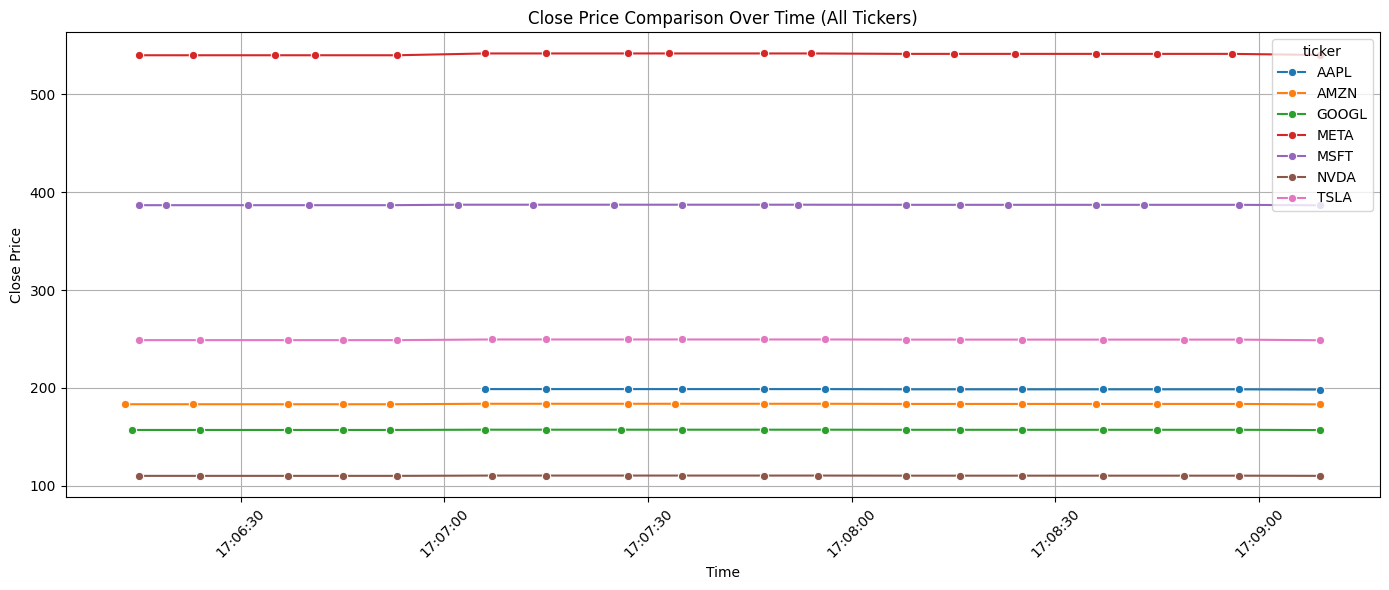

In [13]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_cass_final, x='date', y='close', hue='ticker', marker='o')
plt.title("Close Price Comparison Over Time (All Tickers)")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()



### Above is a line plot comparing all of the 7 companies by their real tiem close price changes. Each dot correlates to 1 quote retrieved at the time stamp. If the dot is missing for a line it was likely nan and dropped. 

In [15]:
import plotly.graph_objects as go

for ticker in df_cass_final['ticker'].unique():
    subset = df_cass_final[df_cass_final['ticker'] == ticker]
    fig = go.Figure(data=[go.Candlestick(
        x=subset['date'],
        open=subset['open'],
        high=subset['high'],
        low=subset['low'],
        close=subset['close']
    )])
    fig.update_layout(title=f"{ticker} Candlestick Chart", xaxis_title='Time', yaxis_title='Price')
    fig.show()


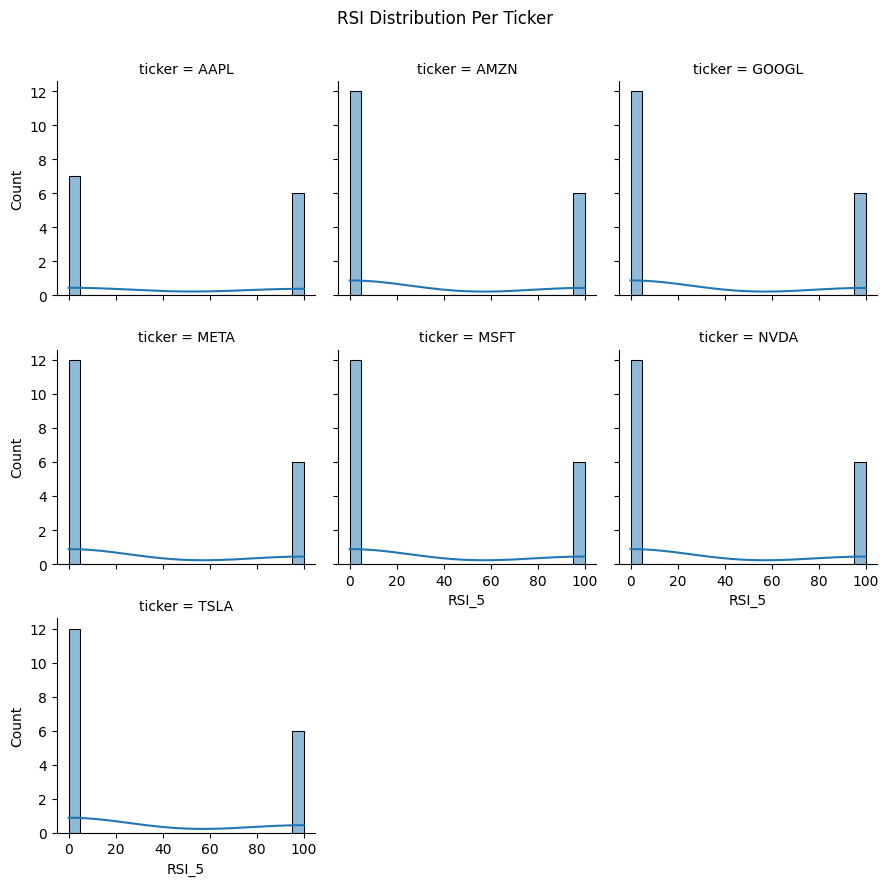

In [69]:
g = sns.FacetGrid(df_cass_final, col="ticker", col_wrap=3, sharex=True, sharey=True)
g.map(sns.histplot, "RSI_5", bins=20, kde=True)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("RSI Distribution Per Ticker")
plt.show()


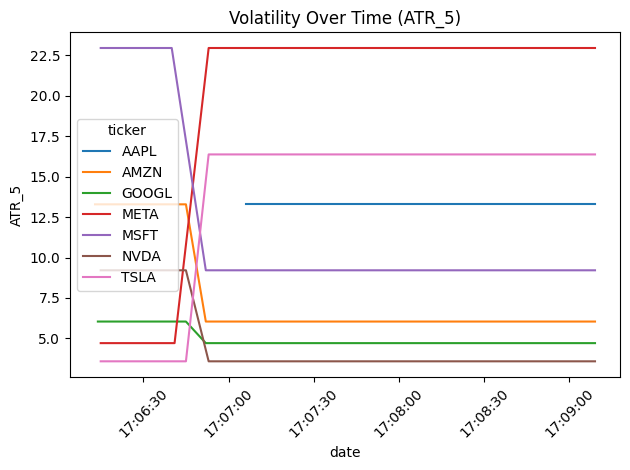

In [59]:
sns.lineplot(data=df_cass_final, x="date", y="ATR_5", hue="ticker")
plt.title("Volatility Over Time (ATR_5)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


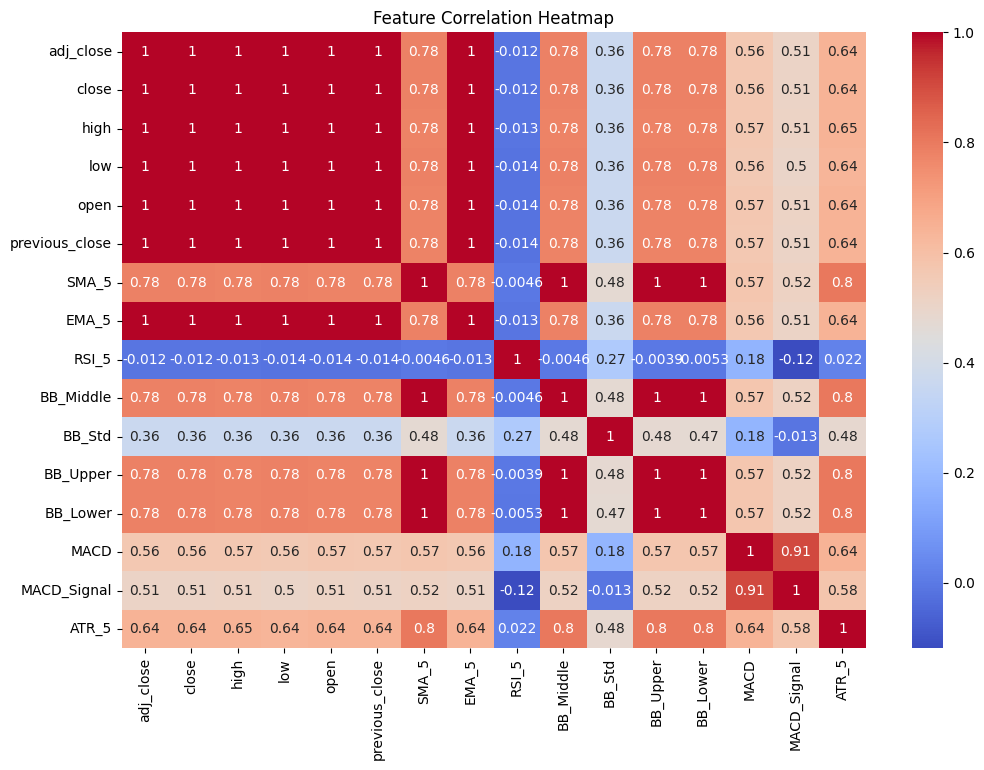

In [60]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_cass_final.drop(columns=['date', 'ticker']).corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()


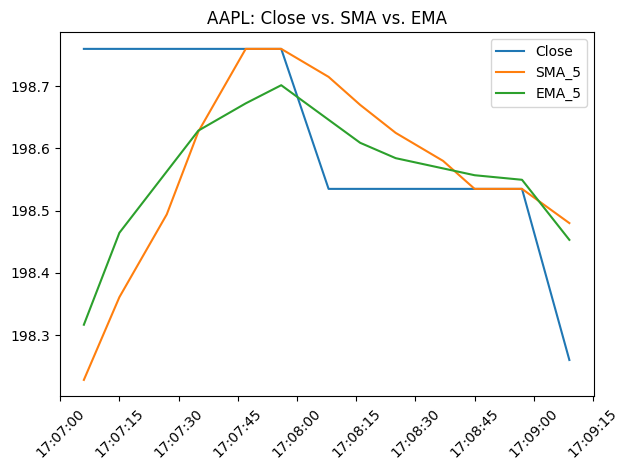

In [61]:
subset = df_cass_final[df_cass_final['ticker'] == 'AAPL']  # or any one ticker
plt.plot(subset['date'], subset['close'], label='Close')
plt.plot(subset['date'], subset['SMA_5'], label='SMA_5')
plt.plot(subset['date'], subset['EMA_5'], label='EMA_5')
plt.title("AAPL: Close vs. SMA vs. EMA")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


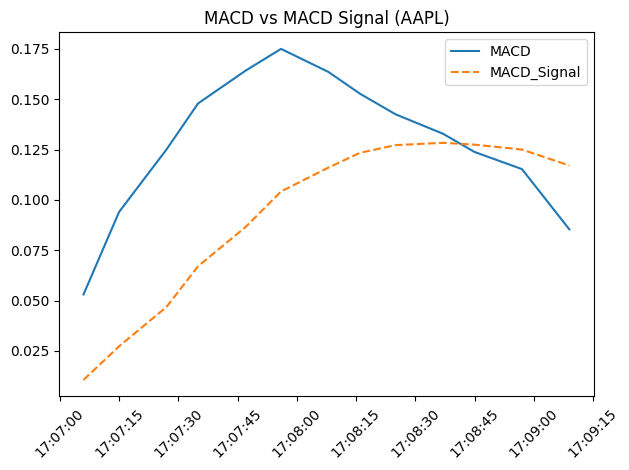

In [62]:
subset = df_cass_final[df_cass_final['ticker'] == 'AAPL']
plt.plot(subset['date'], subset['MACD'], label='MACD')
plt.plot(subset['date'], subset['MACD_Signal'], label='MACD_Signal', linestyle='--')
plt.title("MACD vs MACD Signal (AAPL)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


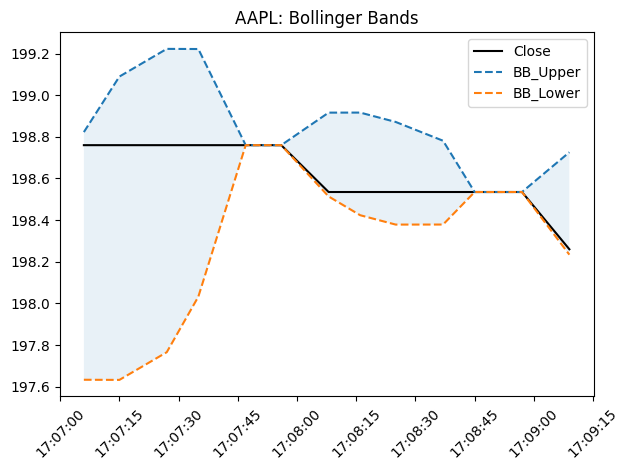

In [63]:
subset = df_cass_final[df_cass_final['ticker'] == 'AAPL']
plt.plot(subset['date'], subset['close'], label='Close', color='black')
plt.plot(subset['date'], subset['BB_Upper'], label='BB_Upper', linestyle='--')
plt.plot(subset['date'], subset['BB_Lower'], label='BB_Lower', linestyle='--')
plt.fill_between(subset['date'], subset['BB_Lower'], subset['BB_Upper'], alpha=0.1)
plt.title("AAPL: Bollinger Bands")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


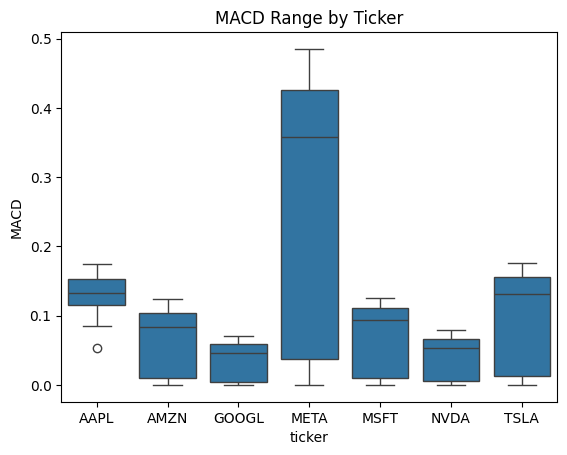

In [64]:
sns.boxplot(data=df_cass_final, x="ticker", y="MACD")
plt.title("MACD Range by Ticker")
plt.show()


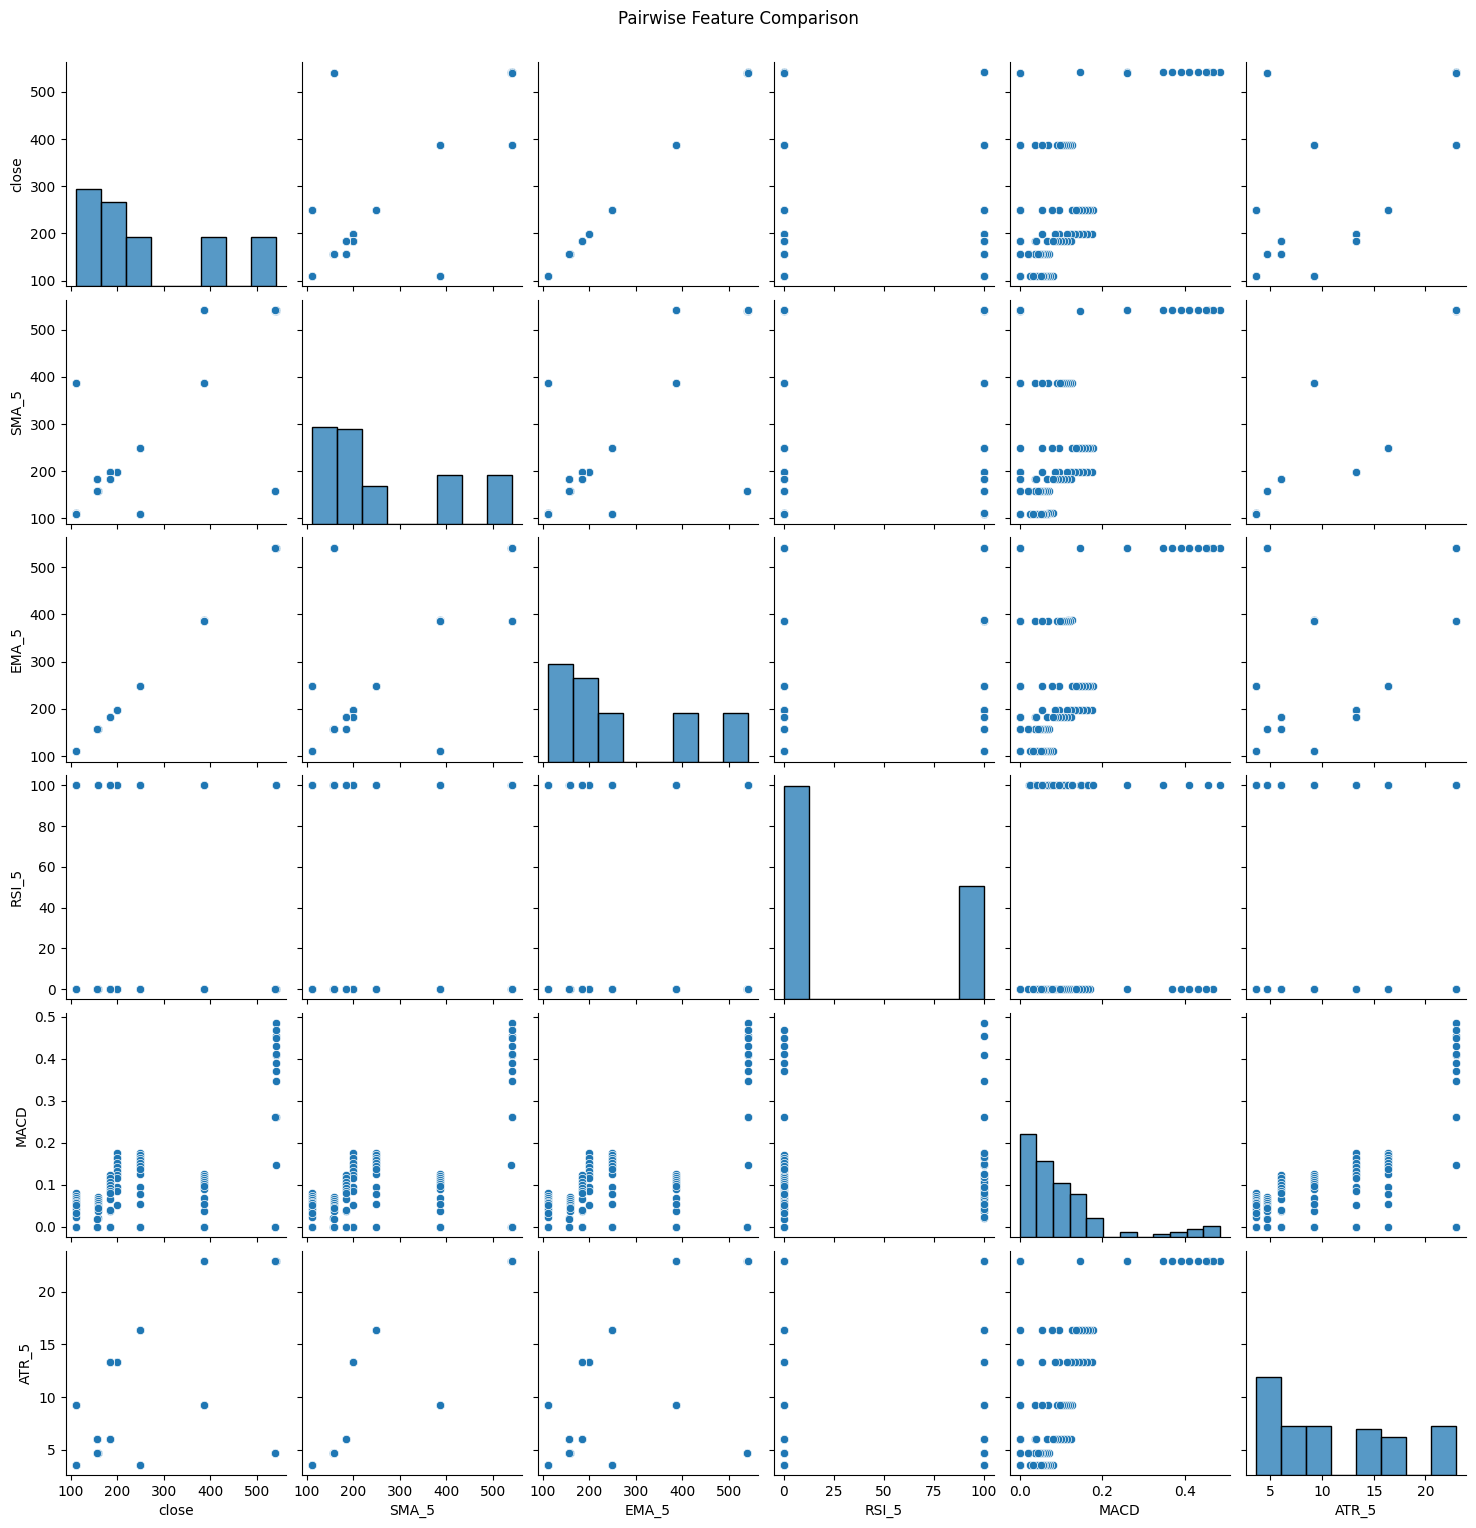

In [65]:
sns.pairplot(df_cass_final[['close', 'SMA_5', 'EMA_5', 'RSI_5', 'MACD', 'ATR_5']])
plt.suptitle("Pairwise Feature Comparison", y=1.02)
plt.show()


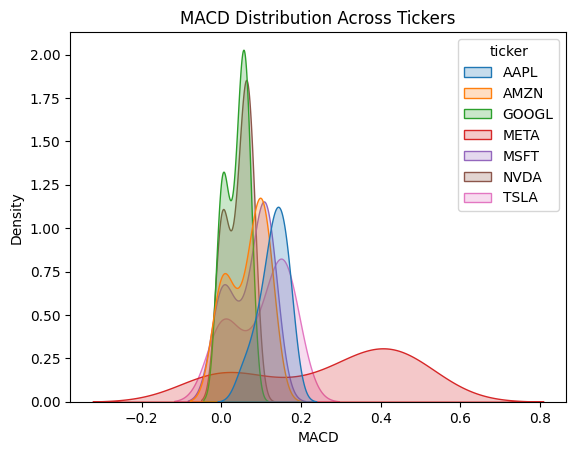

In [66]:
sns.kdeplot(data=df_cass_final, x='MACD', hue='ticker', fill=True)
plt.title("MACD Distribution Across Tickers")
plt.show()


## Real Time Data Encoding

## Machine Learning
### ARIMA for MySQL (historical) and LSTM for Cassandra (real time)